# Check spike spatial variation

author: steeve.laquitaine@epfl.ch

In [14]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)
from src.nodes.postpro import waveform
from src.nodes.utils import get_config, write_metadata
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.dataeng.silico import probe_wiring

# SET PARAMETERS
EXPERIMENT = "supp/silico_reyes"    # specifies the experiment 
SIMULATION_DATE = "2023_01_13" # specifies the run (date)
MS_BEFORE = 3       # ms
MS_AFTER = 3        # ms
CELL_ID = 3754013   # the most active near-probe pyramidal cell
CHANNEL_IDS = np.arange(64,80).tolist()   # plot traces from channels nearest to filtered neuron group

# SETUP CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SETUP PATH
SPIKE_FILE_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["input"]
RAW_LFP_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["trace_file_path"]
CELL_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["unit_trace_path"]+"cell_3754013_trace.pkl"


# SET WAVEFORM FOLDER
STUDY_FOLDER = data_conf["postprocessing"]["waveform"]["study"]


# FIGURE
FIG_PATH = data_conf["figures"]["silico"]["spike_spatial_variation"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-03-03 10:25:25,028 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-03 10:25:25,072 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Check spike SNR and consistency 

1. We preprocess the raw LFP traces
2. We extract the waveforms within -3 to 3 ms centered on the spike timestamps of the most active pyramidal to have a large enough spike sample size.
3. We plot the spike-triggered average of each contact
4. We plot the neuron and contact locations associated with each spike triggered average

In [5]:
# Preprocess traces and extract spikes (stats: 3 min for a 40 secs campaign, 1000 cells)
WaveformExtractor = waveform.run_from_files(
    experiment=EXPERIMENT,
    simulation_date=SIMULATION_DATE,
    lfp_trace_file=RAW_LFP_TRACE_FILE_PATH,
    spike_file=SPIKE_FILE_PATH,
    study_folder=STUDY_FOLDER,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

2023-03-03 10:13:40,966 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-03 10:13:41,028 - root - utils.py - get_config - INFO - Reading experiment config. - done
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


```diff
- Result: The spike waveforms of an example active pyramidal cell within 50 microns of a probe contact (green lines), overlaid on a spike triggered average plot, are clearly visible (above background noise) and consistent over time. But some 
```
Remarks TODO: 
* Some spikes do not look like spikes at all.
    * Hypothesis 1: these have the fewest samples (sometimes only one spike)
* Some spikes precede the timestamp. 
    * Hypothesis 1: what's visible is not our target cell's spikes but another cell's spikes, which would often precede our target cell's spikes)


## Get near-contact pyramidal cells

In [6]:
# get near-contact pyramidal cells (stats: 2 min)
simulation = load_campaign_params(data_conf)
Truth = ground_truth.run(simulation, data_conf, param_conf)[
    "ground_truth_sorting_object"
]
cell_morph = simulation["circuit"].cells.get(Truth.unit_ids, properties=["morph_class"])
CELL_IDS = cell_morph[cell_morph["morph_class"] == "PYR"].index.values
print("near-contact pyr. cells (count): ", len(CELL_IDS))

2023-03-03 10:22:04,531 - root - ground_truth.py - create_sorting_object - INFO - Creating and writing SpikeInterface's Sorting extractor object...
near-contact pyr. cells (count):  1090


In [26]:
# WARNIN !! for each pyramidal cell (very slow takes 1h-ish)
for cell_i in CELL_IDS:

    # compute waveform plot
    fig = waveform.plot(WaveformExtractor=WaveformExtractor, cell_id=cell_i)

    # write
    if not os.path.isdir(f"{FIG_PATH}pyramidal/"):
        os.makedirs(f"{FIG_PATH}pyramidal/")
    fig.savefig(f"{FIG_PATH}pyramidal/cell_{cell_i}", dpi=300, bbox_inches="tight")

# show
# plt.show()

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/waveform.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 3))


## Check spike spatial variation

`Result: The spike waveforms are most visible on channel (71) on which it has maximum positive and negative amplitudes and nearby channels (72,73,74) in agreement with its estimated location on channel 72, rightward to channel 71.`

In [15]:
# fig = waveform.plot_by_channel(WaveformExtractor, channel_ids=CHANNEL_IDS, cell_id=CELL_ID, figsize=(2,35))
# print("cell's waveforms (green) and its median (Fuchsia) by channel (pannels)")

In [9]:
# get chosen cell's coordinate
cell_coord = simulation["circuit"].cells.get(CELL_ID, properties=["x", "y", "z"])
print("cell coordinates:\n", cell_coord)

# wire the recording with its probe and get the probe's contact coordinates
recording = probe_wiring.run(data_conf, param_conf)
probe_wiring.write(recording, data_conf)
probe = recording.get_probe()
probe_coord = probe.contact_positions.astype(float)
print("contact x-y coordinates:\n", probe_coord[:, :1])

cell coordinates:
 x    3820.476353
y     -1143.5028
z   -2538.452514
Name: 3754013, dtype: object
write_binary_recording with n_jobs = 1 and chunk_size = None
2023-03-03 10:23:25,734 - root - probe_wiring.py - write - INFO - Probe wiring done in  8.8 secs
2023-03-03 10:23:25,735 - root - probe_wiring.py - write - INFO - Probe wiring done in  8.8 secs
2023-03-03 10:23:25,736 - root - probe_wiring.py - write - INFO - Probe wiring done in  8.8 secs
contact x-y coordinates:
 [[3333.81242423]
 [3378.99014513]
 [3424.16786603]
 [3469.34558693]
 [3514.52330784]
 [3559.70102874]
 [3604.87874964]
 [3650.05647054]
 [3695.23419145]
 [3740.41191235]
 [3785.58963325]
 [3830.76735415]
 [3875.94507506]
 [3921.12279596]
 [3966.30051686]
 [4011.47823777]
 [3382.43500685]
 [3427.61272776]
 [3472.79044866]
 [3517.96816956]
 [3563.14589046]
 [3608.32361137]
 [3653.50133227]
 [3698.67905317]
 [3743.85677407]
 [3789.03449498]
 [3834.21221588]
 [3879.38993678]
 [3924.56765769]
 [3969.74537859]
 [4014.923099

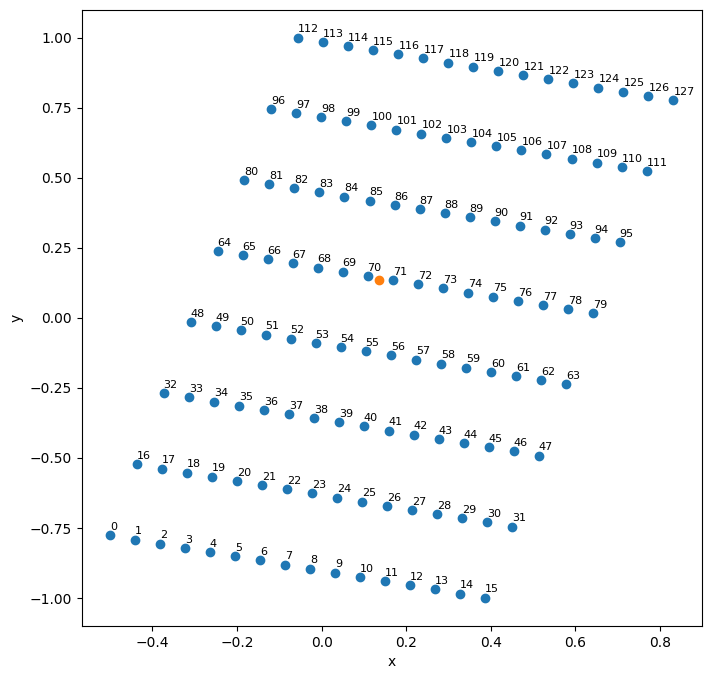

In [10]:
# scale coordinates linearly between -1 and 1 for plot (0 being the cell coordinates)
norm_contact_coord = np.subtract(probe_coord[:, :2], cell_coord.values[:2])
ncc = norm_contact_coord
ncc_max = norm_contact_coord.max().max()
ncc_min = norm_contact_coord.min().min()
scaled_contact_coord = (ncc - ncc_min) / (ncc_max - ncc_min) * 2 - 1

# normalize cell
norm_cell_coord = np.array([0, 0])
scaled_cell_coords = (norm_cell_coord - ncc_min) / (ncc_max - ncc_min) * 2 - 1

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(scaled_contact_coord[:, 0], scaled_contact_coord[:, 1], "o")
ax.plot(scaled_cell_coords[0], scaled_cell_coords[1], "o")
ax.set_xlabel("x")
ax.set_ylabel("y")

contact_ids = probe.device_channel_indices

# annotate contacts with their ids
for ix in range(len(probe_coord)):
    ax.text(
        scaled_contact_coord[ix, 0],
        scaled_contact_coord[ix, 1] + 0.02,
        "%s" % (str(contact_ids[ix])),
        size=8,
        zorder=1,
        color="k",
    )

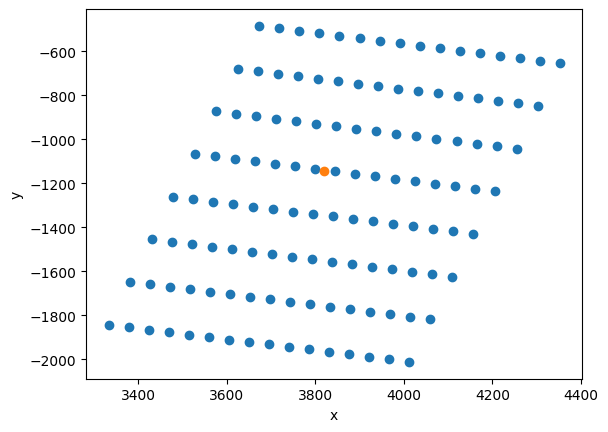

In [11]:
# test that the euclidean distances are preserved compared to the raw coordinates
plt.plot(probe_coord[:, 0], probe_coord[:, 1], "o")
plt.plot(cell_coord.x, cell_coord.y, "o")
plt.xlabel("x")
plt.ylabel("y")

TODO:
- Color each trace by its peak to peak amplitude (like in Buszaki, koch JN paper)

contacts (numbers), median spike (lines), pyramidal cell (red dot). The contacts are located at the center of each spike panel.
channels (color)


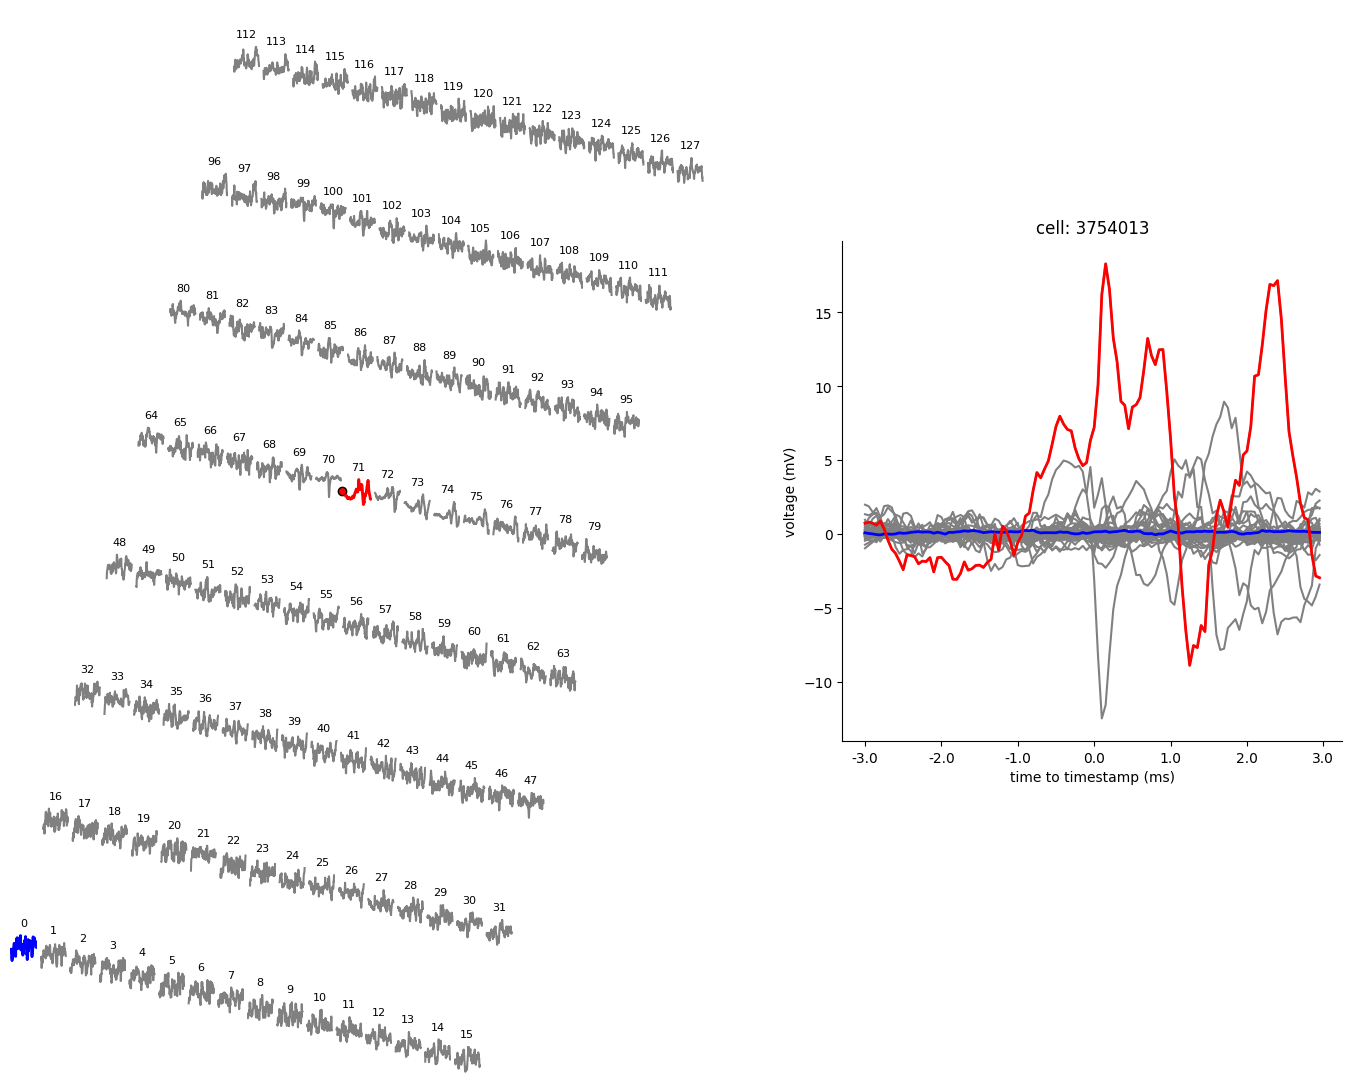

In [63]:
# setup plot
fig = plt.figure(figsize=(5, 5))

# Plot spatial variation
# --------------------
# create plane and panel parameters
x_y_plane = [0.1, 0.1, 1, 1]
panel_width = 0.055

# plot x-y-plane
ax = fig.add_axes(x_y_plane)
ax.axis("off")

# plot cell panel in the x-y plane
coord_cell_panel = [
    scaled_cell_coords[0] - panel_width / 2,
    scaled_cell_coords[1] - panel_width / 2,
    panel_width,
    panel_width,
]
ax0 = fig.add_axes(coord_cell_panel)
ax0.plot(0.0, marker="o", markerfacecolor="r", markeredgecolor="k")
ax0.axis("off")

median_spike = WaveformExtractor.get_template(unit_id=CELL_ID, mode="median")

DISTANT_CHANNEL = 0
NEARBY_CHANNEL = 71

# plot each contact's average spike panel in the x-y plane
for ix in range(len(scaled_contact_coord)):

    # center each panel on the associated contact coordinate
    coord_contact_i = [
        scaled_contact_coord[ix, 0] - panel_width / 2,
        scaled_contact_coord[ix, 1] - panel_width / 2,
        panel_width,
        panel_width,
    ]

    # contact
    ax0 = fig.add_axes(coord_contact_i)
    ax0.plot(median_spike[:, ix], color=[0.5, 0.5, 0.5])
    if ix == DISTANT_CHANNEL:
        ax0.plot(median_spike[:, ix], color="b", linewidth=2)
    if ix == NEARBY_CHANNEL:
        ax0.plot(median_spike[:, ix], color="r", linewidth=2)
    ax0.axis("off")
    ax0.set_title(ix, fontsize=8)

print(
    "contacts (numbers), median spike (lines), pyramidal cell (red dot). The contacts are located at the center of each spike panel."
)

# get unit waveforms (n_spikes, n_sample, n_channels)
wfs = WaveformExtractor.get_waveforms(CELL_ID)

# plot unit median waveforms by channel on the same level as the cell's y-axis
# to see spike amplitude difference
panel_width = 1
panel_offset = 1.5
x_y_plane2 = [
    scaled_cell_coords[0] - panel_width / 2 + panel_offset,
    scaled_cell_coords[1] - panel_width / 2,
    panel_width,
    panel_width,
]
ax1 = fig.add_axes(x_y_plane2)
median_spike = WaveformExtractor.get_template(unit_id=CELL_ID, mode="median")
ax1.plot(median_spike, color=[0.5, 0.5, 0.5])
ax1.plot(median_spike[:, DISTANT_CHANNEL], color="b", linewidth=2)
ax1.plot(median_spike[:, NEARBY_CHANNEL], color="r", linewidth=2)

ms_timestep = 6 / median_spike.shape[0]
x_ticklabels = np.arange(-ms_timestep * 60, ms_timestep * 60 + 1)
x_ticks = np.arange(0, 121, 1 / 0.05)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticklabels)
ax1.set_xlabel("time to timestamp (ms)")
ax1.set_ylabel("voltage (mV)")

ax1.spines[["right", "top"]].set_visible(False)
ax1.set_title(f"cell: {CELL_ID}")
print("channels (color)")

In [64]:
# TODO:
# - I do a screenshot for now, but need to implement automatic saving

# # save figure
# fig.savefig(FIG_PATH+".png")

# # write metadata
# metadata = {
#     "fig_path": FIG_PATH,
#     "creation_date": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
#     "simulation_date": SIMULATION_DATE,
#     "data_conf": data_conf,
#     "param_conf": param_conf,
#     }
# write_metadata(metadata, FIG_PATH)